In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras import backend as K
from keras.layers import Layer, Input, Conv2D, MaxPooling2D
import tensorflow as tf

In [2]:
#base_model test
import base_model
base = base_model.Base()
fmap = base.get_fmap()
base.get_config()

{'name': 'base',
 'trainable': True,
 'dtype': 'float32',
 'base': 'VGG16',
 'channels': 3,
 'input_shape': TensorShape([None, None, None, 3]),
 'fmap_shape': TensorShape([None, None, None, 512])}

In [3]:
#pooling test
import roi_pooling

#test pool.call after the rois are generated
pool = roi_pooling.RoIPooling(pool_size = 7, num_rois = 1)
pool.get_config()

{'name': 'ro_i_pooling',
 'trainable': True,
 'dtype': 'float32',
 'pool_size': 7,
 'num_rois': 1}

## Testing Region Proposals (generate.py)

In [4]:
from rpn.generate_anchors import generate_anchor_boxes
import config as C

#if image big, we resize it
def resize(img):
    w,h,_ = img.shape
    if w>h:
        scaling_factor = h/600
    else:
        scaling_factor = w/600
    return cv2.resize(img,(int(h/scaling_factor),int(w/scaling_factor)))

def plot_rectangles(imdb,img):
    for idx in range(len(imdb)):
        im = imdb.loc[idx]
        #print(im['x1'],im['y1'],im['x2'],im['y2'])
        if im['class']!='bg':
            cv2.rectangle(img,(int(im['x1']),int(im['y1'])),(int(im['x2']),int(im['y2'])),(255,0,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(img[:,:,[2,1,0]])

def plot_boxes(img, y_rpn_cls):
    anchor_ratios = C.anchor_box_ratios
    anchor_scales = C.anchor_box_scales
    pos_cnt,neg_cnt=0,0
    downscale = C.rpn_stride
    bboxes = np.where(y_rpn_cls[:,:,:,:9])
    for i in range(len(bboxes[0])):
        w_idx, h_idx = bboxes[1][i], bboxes[2][i]
        if y_rpn_cls[0,w_idx,h_idx,bboxes[3][i]+9]:
            bbox_type='pos'
            pos_cnt+=1
        else:
            bbox_type='neg'
            neg_cnt+=1
        anchor_scale_idx = bboxes[3][i]//len(anchor_ratios)
        anchor_ratio_idx = bboxes[3][i]%len(anchor_ratios)
        w = anchor_scales[anchor_scale_idx]*anchor_ratios[anchor_ratio_idx][0]
        h = anchor_scales[anchor_scale_idx]*anchor_ratios[anchor_ratio_idx][1]
        x1 = int(downscale*w_idx - w/2)
        y1 = int(downscale*h_idx - h/2)
        x2 = int(downscale*w_idx + w/2)
        y2 = int(downscale*h_idx + h/2)
        if bbox_type=='pos':
            color = (0,255,0)
        #else:
        #    color = (0,0,255)
            cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    print("pos_cnt: {}, neg_cnt: {}".format(pos_cnt, neg_cnt))

## Test Image 1

(640, 640, 3)


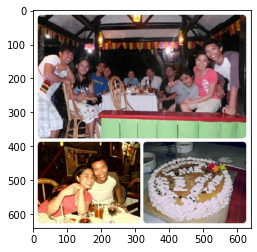

In [5]:
img = cv2.imread("test_img/img1.jpg")
bbox = pd.read_csv("test_img/test_bbox1.csv")
cls_labels = pd.read_csv("test_img/class_labels1.csv")
plt.imshow(img[:,:,[2,1,0]])
print(img.shape)

In [6]:
img = resize(img)
print(img.shape)

(600, 600, 3)


In [7]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [8]:
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
cls_labels

,Name,Class
0,/m/01g317,Person
1,/m/0284d,Dairy
2,/m/04bcr3,Table
3,/m/0fszt,Cake
4,/m/0hnyx,Pastry


In [9]:
imdb = pd.DataFrame()
imdb['x1'] = bbox['XMin']*img.shape[1]
imdb['x2'] = bbox['XMax']*img.shape[1]
imdb['y1'] = bbox['YMin']*img.shape[0]
imdb['y2'] = bbox['YMax']*img.shape[0]

imdb['class']=bbox.join(cls_labels.set_index('Name'),on='LabelName')['Class']
imdb

,x1,x2,y1,y2,class
0,7.5000,117.1872,89.0628,352.5000,Person
1,15.0000,165.9378,428.4378,569.0628,Person
2,90.9372,186.5622,119.0622,354.3750,Person
3,153.7500,257.8128,390.9378,555.0000,Person
4,154.6872,208.1250,141.5628,231.5628,Person
5,192.1872,221.2500,156.5628,196.8750,Person
6,247.5000,567.1872,72.1872,285.0000,Person
7,316.8750,554.0622,405.0000,578.4378,Dairy
8,38.4372,295.3128,533.4378,596.2500,Table
9,180.9372,594.3750,277.5000,357.1872,Table


In [10]:
imdb['class'].loc[imdb['class']!='Person']='bg'
imdb

C:\Users\april\Anaconda3\envs\gpu\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,x1,x2,y1,y2,class
0,7.5000,117.1872,89.0628,352.5000,Person
1,15.0000,165.9378,428.4378,569.0628,Person
2,90.9372,186.5622,119.0622,354.3750,Person
3,153.7500,257.8128,390.9378,555.0000,Person
4,154.6872,208.1250,141.5628,231.5628,Person
5,192.1872,221.2500,156.5628,196.8750,Person
6,247.5000,567.1872,72.1872,285.0000,Person
7,316.8750,554.0622,405.0000,578.4378,bg
8,38.4372,295.3128,533.4378,596.2500,bg
9,180.9372,594.3750,277.5000,357.1872,bg


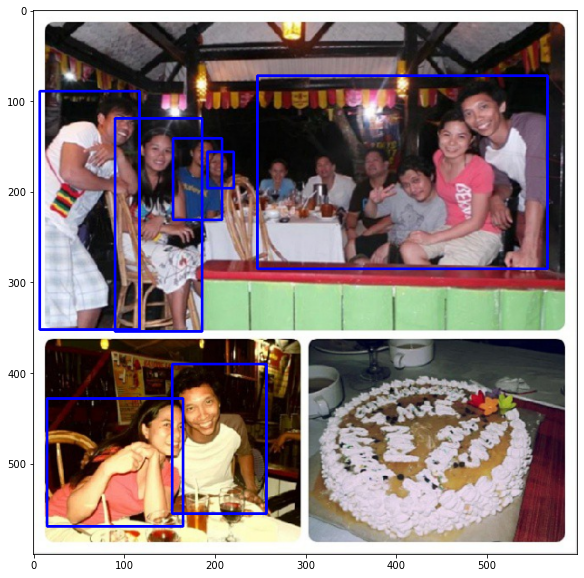

In [11]:
#plotting rectangles
plot_rectangles(imdb,img)

In [12]:
y_rpn_cls, y_rpn_regr, num_pos = generate_anchor_boxes(imdb,img.shape[0],img.shape[1],img.shape[0],img.shape[1])
print(y_rpn_cls.shape, y_rpn_regr.shape, num_pos)

(1, 37, 37, 18) (1, 37, 37, 72) 22


pos_cnt: 22, neg_cnt: 234


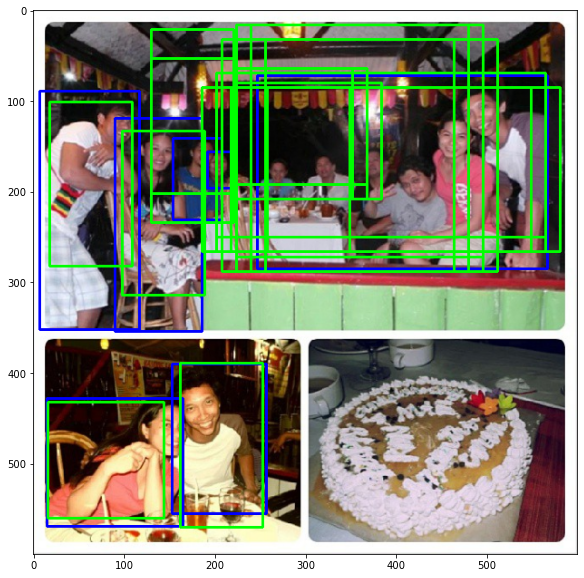

In [13]:
plot_boxes(img,y_rpn_cls)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,[2,1,0]])

## Test Image 2

(1067, 1600, 3)


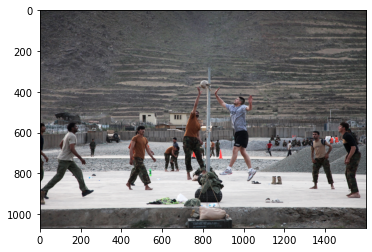

In [14]:
img = cv2.imread("test_img/img2.jpg")
bbox = pd.read_csv("test_img/test_bbox2.csv")
cls_labels = pd.read_csv("test_img/class_labels2.csv")
plt.imshow(img[:,:,[2,1,0]])
print(img.shape)

In [15]:
img = resize(img)
print(img.shape)

(600, 899, 3)


In [16]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,82af8aeb62a3e757,xclick,/m/04yx4,1,0.000000,0.029375,0.516401,0.789128,0,1,0,0,0
1,82af8aeb62a3e757,xclick,/m/04yx4,1,0.000000,0.171250,0.509841,0.895033,0,1,0,0,0
2,82af8aeb62a3e757,xclick,/m/04yx4,1,0.150000,0.173750,0.588566,0.675726,0,0,0,0,0
3,82af8aeb62a3e757,xclick,/m/04yx4,1,0.261875,0.352500,0.531396,0.829428,0,0,0,0,0
4,82af8aeb62a3e757,xclick,/m/04yx4,1,0.268125,0.344375,0.559513,0.807873,1,0,0,0,0
5,82af8aeb62a3e757,xclick,/m/04yx4,1,0.378750,0.428750,0.622306,0.740394,0,0,0,0,0
6,82af8aeb62a3e757,xclick,/m/04yx4,1,0.400000,0.430000,0.584817,0.744142,1,0,0,0,0
7,82af8aeb62a3e757,xclick,/m/04yx4,1,0.435000,0.514375,0.348641,0.783505,1,0,0,0,0
8,82af8aeb62a3e757,xclick,/m/04yx4,1,0.530000,0.665000,0.349578,0.784442,0,0,0,0,0
9,82af8aeb62a3e757,xclick,/m/04yx4,1,0.536250,0.555000,0.597001,0.675726,1,0,0,0,0


In [17]:
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
cls_labels

,Name,Class
0,/m/04yx4,Man
1,/m/09j5n,Footwear


In [18]:
imdb = pd.DataFrame()
imdb['x1'] = bbox['XMin']*img.shape[1]
imdb['x2'] = bbox['XMax']*img.shape[1]
imdb['y1'] = bbox['YMin']*img.shape[0]
imdb['y2'] = bbox['YMax']*img.shape[0]

imdb['class']=bbox.join(cls_labels.set_index('Name'),on='LabelName')['Class']
imdb

,x1,x2,y1,y2,class
0,0.000000,26.408125,309.8406,473.4768,Man
1,0.000000,153.953750,305.9046,537.0198,Man
2,134.850000,156.201250,353.1396,405.4356,Man
3,235.425625,316.897500,318.8376,497.6568,Man
4,241.044375,309.593125,335.7078,484.7238,Man
5,340.496250,385.446250,373.3836,444.2364,Man
6,359.600000,386.570000,350.8902,446.4852,Man
7,391.065000,462.423125,209.1846,470.1030,Man
8,476.470000,597.835000,209.7468,470.6652,Man
9,482.088750,498.945000,358.2006,405.4356,Man


In [19]:
imdb['class'].loc[imdb['class']!='Man']='bg'
imdb

C:\Users\april\Anaconda3\envs\gpu\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,x1,x2,y1,y2,class
0,0.000000,26.408125,309.8406,473.4768,Man
1,0.000000,153.953750,305.9046,537.0198,Man
2,134.850000,156.201250,353.1396,405.4356,Man
3,235.425625,316.897500,318.8376,497.6568,Man
4,241.044375,309.593125,335.7078,484.7238,Man
5,340.496250,385.446250,373.3836,444.2364,Man
6,359.600000,386.570000,350.8902,446.4852,Man
7,391.065000,462.423125,209.1846,470.1030,Man
8,476.470000,597.835000,209.7468,470.6652,Man
9,482.088750,498.945000,358.2006,405.4356,Man


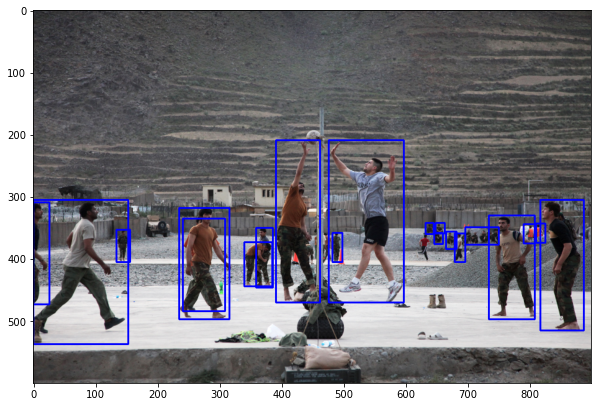

In [20]:
#plotting rectangles
plot_rectangles(imdb,img)

In [21]:
y_rpn_cls, y_rpn_regr, num_pos = generate_anchor_boxes(imdb,img.shape[0],img.shape[1],img.shape[0],img.shape[1])
print(y_rpn_cls.shape, y_rpn_regr.shape, num_pos)

(1, 37, 56, 18) (1, 37, 56, 72) 28


pos_cnt: 28, neg_cnt: 228


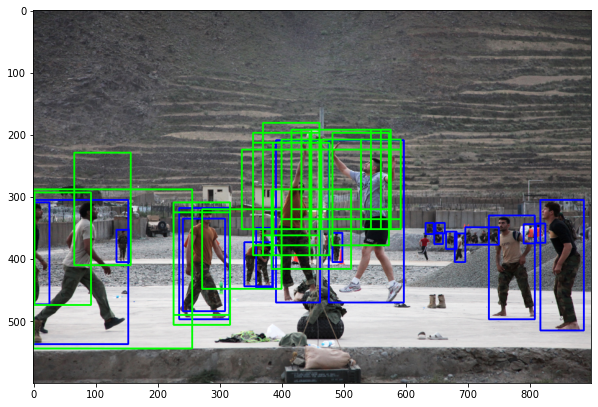

In [22]:
plot_boxes(img,y_rpn_cls)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,[2,1,0]])